In [1]:
import sys
sys.path.insert(0, "../../src/")
from framework import *
from algorithms import nelder_mead_multi

# convert the float number to latex format
def float_to_latex(float_number):
    import math
    if float('inf') == float_number:
        return "\\( +\\infty \\)"
    # Extracting the exponent part
    exponent = int(math.floor(math.log10(abs(float_number))))

    # Extracting the mantissa part
    mantissa = float_number / (10 ** exponent)

    # Formatting the float number in the LaTeX style format
    latex_formatted_number = "\\({:.2f} \\times 10^{{{}}}\\)".format(mantissa, exponent)
    return latex_formatted_number

def params_to_latex(ins, int_fields=[]):
    d = ins.trial.params
    for k, v in d.items():
        kk = k.replace('_', '\\_')
        if k in int_fields:
            print(f'& \\texttt{{{kk}}} & {v} \\\\')
        else:
            print(f'& \\texttt{{{kk}}} & {float_to_latex(v)} \\\\')

def performance_to_latex(ins):
    run_num = len(ins.results)
    d = ins.performance_measures()
    sr = d['success_rate']
    ah = d['avg_height']
    ert = d['ert']
    gert = d['gary_ert']
    print(ins.algorithm.name.replace('_', ' '), end='\t')
    print(f'& {run_num}', end='\t')
    print(f'& {round(sr * 100)}\\%', end='\t')
    print(f'& {round(ah)}', end='\t')
    print(f'& {float_to_latex(ert)} ', end='\t')
    print(f'& {float_to_latex(gert)} ', end='\\\\')

In [2]:
nelder_mead_multi.load_best_instance('../../result/apr.db')
save_handler = SaveHandlerJSON('../../result/apr/')

nm_ins = nelder_mead_multi.best_instance
nm_ins.trial.params

{}

In [3]:
nm_ins.run(
    save_handler=save_handler,
    save_partial=False,
    restart=True,
    does_prune=False,
)

1036927it [00:30, 33559.86it/s]                            


In [4]:
nm_ins.performance_measures()

{'success_rate': 0.25,
 'failure_rate': 0.75,
 'success_cnt': 6,
 'avg_success_eval': 22821.166666666668,
 'hv': 6794.708333333333,
 'par2': 80705.29166666667,
 'par10': 380705.2916666667,
 'avg_height': 1320.3137966615043,
 'ert': 172821.16666666666,
 'sp': 91284.66666666667,
 'success_rate_upper': 0.44899825312106434,
 'success_rate_lower': 0.11999203479342332,
 'success_rate_length': 0.32900621832764104,
 'gary_ert': 8295.416}

In [5]:
performance_to_latex(nm_ins)

Nelder-Mead Multi	& 24	& 25\%	& 1320	& \(1.73 \times 10^{5}\) 	& \(8.30 \times 10^{3}\) \\

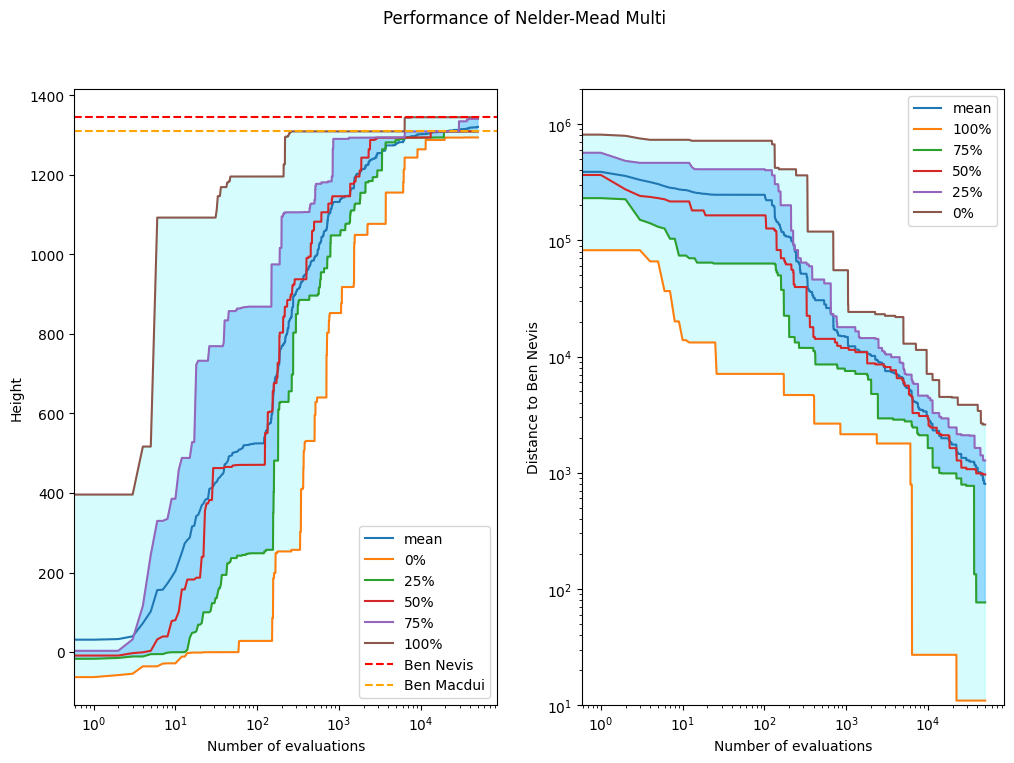

In [6]:
nm_ins.plot_convergence_graph()

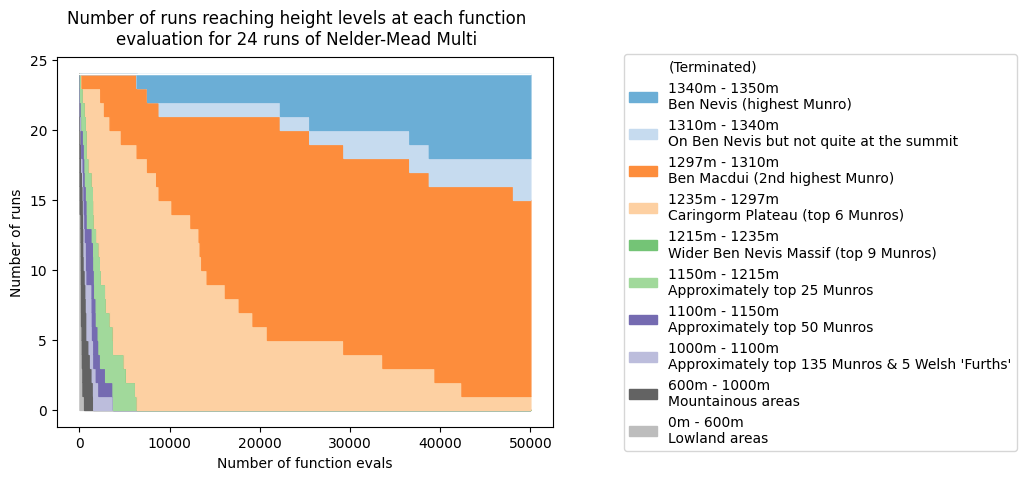

In [7]:
nm_ins.plot_stacked_graph()

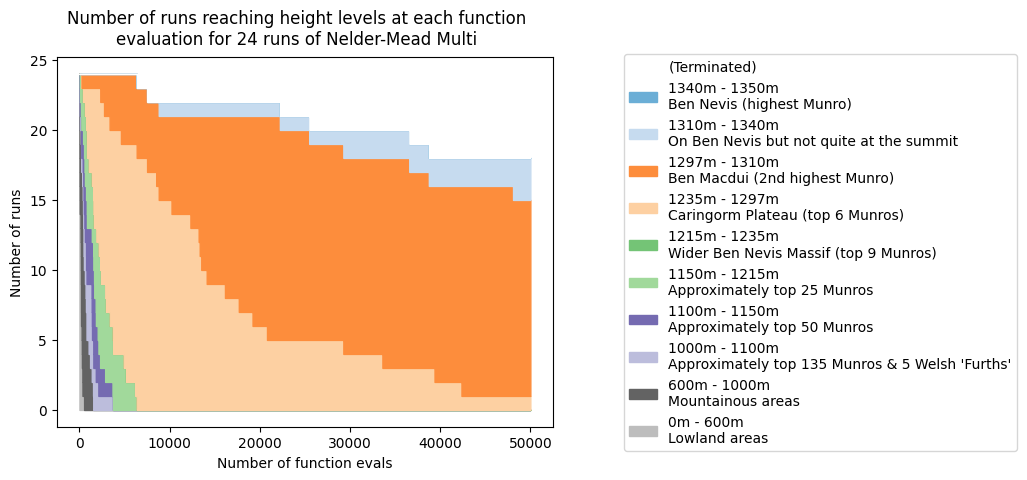

In [8]:
nm_ins.plot_stacked_graph(mode='terminate')

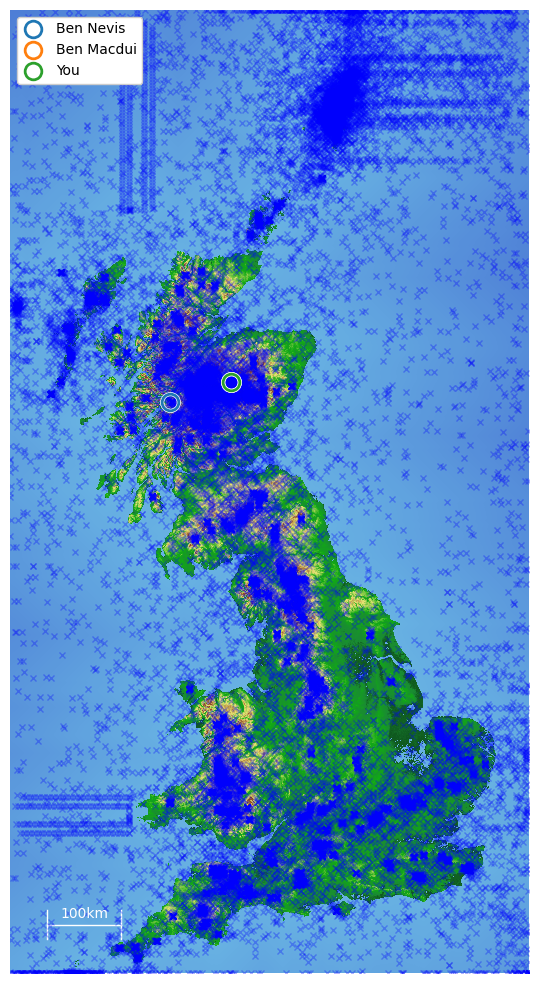

In [9]:
res = nm_ins.results[4]
res.plot_global()